# 1 - Import requirements

In [1]:
# !pip install pytorch-optimizer

In [2]:
import os
import math
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
# from pytorch_optimizer import SAM

from tqdm import tqdm

# 2 - Prepare data

In [3]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

In [4]:
def load_shape(shape_path):
    with open(shape_path, 'r') as f:
        shape = f.readlines()
        n_samples = int(shape[0])
        seq_len = int(shape[1])
        n_features = int(shape[2])
    return n_samples, seq_len, n_features

class TradingDataset(Dataset):
    def __init__(self, save_path, n_samples, sequence_length, n_features):
        self.save_path = save_path
        self.n_samples = n_samples
        self.sequences = np.memmap(f'{save_path}/sequences.dat', dtype=np.float32, mode='r', 
                                 shape=(n_samples, sequence_length, n_features))
        self.labels = np.memmap(f'{save_path}/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_samples,))
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].copy()  # Tạo bản sao writable
        lbl = self.labels[idx].copy()
        return torch.from_numpy(seq).float(), torch.from_numpy(np.array([lbl])).long()[0]

def prepare_transformer_input(train_shape_path, val_shape_path, test_shape_path, data_path, batch_size=32):    
    n_train_samples, sequence_length, n_features = load_shape(train_shape_path)
    n_val_samples, _, _ = load_shape(val_shape_path)
    n_test_samples, _, _ = load_shape(test_shape_path)
    
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    test_path = f'{data_path}/test'
    
    # Tạo datasets
    train_dataset = TradingDataset(train_path, n_train_samples, sequence_length, n_features)
    val_dataset = TradingDataset(val_path, n_val_samples, sequence_length, n_features)
    test_dataset = TradingDataset(test_path, n_test_samples, sequence_length, n_features)
    
    # Tạo dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [5]:
train_shape_path = '/kaggle/input/processed-xauusd/classification/train/shape.txt'
val_shape_path = '/kaggle/input/processed-xauusd/classification/val/shape.txt'
test_shape_path = '/kaggle/input/processed-xauusd/classification/test/shape.txt'

train_loader, val_loader, test_loader = prepare_transformer_input(
    train_shape_path, val_shape_path, test_shape_path,
    data_path='/kaggle/input/processed-xauusd/classification',
    batch_size=32
)

In [6]:
# Kiểm tra
sample_batch = next(iter(train_loader))
print("Batch input shape:", sample_batch[0].shape)
print("Batch labels shape:", sample_batch[1].shape)
print("\nExample input shape for Transformer:", sample_batch[0][0].shape)
print(sample_batch[0][0])
print("Number of batches:", len(train_loader))

Batch input shape: torch.Size([32, 128, 121])
Batch labels shape: torch.Size([32])

Example input shape for Transformer: torch.Size([128, 121])
tensor([[-6.5006e-01, -2.1643e-01, -1.5026e+00,  ..., -9.4268e-01,
          8.3176e-01,  8.9499e-01],
        [-4.3161e-01,  5.0714e-01,  1.6777e+00,  ..., -9.4268e-01,
          8.3176e-01,  8.9499e-01],
        [-4.3161e-01,  6.4077e-04,  3.8234e-03,  ..., -9.4268e-01,
          8.3176e-01,  8.9499e-01],
        ...,
        [-4.5147e-01, -4.7598e-02, -1.6356e-01,  ..., -1.3160e+00,
          8.3176e-01,  8.9499e-01],
        [-6.5006e-01,  2.1771e-01,  1.5103e+00,  ..., -1.3160e+00,
          8.3176e-01,  8.9499e-01],
        [-6.3020e-01,  4.8879e-02,  3.0816e-01,  ..., -1.3160e+00,
          8.3176e-01,  8.9499e-01]])
Number of batches: 3282


# 3 - Build model

In [7]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, 32, kernel_size=1, padding='same')
        self.branch3 = nn.Conv1d(in_channels, 32, kernel_size=3, padding='same')
        self.branch5 = nn.Conv1d(in_channels, 32, kernel_size=5, padding='same')
        self.branch_pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, 32, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch3(x), self.branch5(x), self.branch_pool(x)], dim=1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CrossAttentionFusion(nn.Module):
    def __init__(self, cnn_dim, transformer_dim):
        super().__init__()
        self.query = nn.Linear(cnn_dim, transformer_dim)
        self.key = nn.Linear(transformer_dim, transformer_dim)
        self.value = nn.Linear(transformer_dim, transformer_dim)
        
    def forward(self, cnn_features, transformer_features):
        # cnn_features: [batch, cnn_dim]
        # transformer_features: [batch, seq_len, transformer_dim]
        Q = self.query(cnn_features).unsqueeze(1)  # [batch, 1, transformer_dim]
        K = self.key(transformer_features)         # [batch, seq_len, transformer_dim]
        V = self.value(transformer_features)       # [batch, seq_len, transformer_dim]
        
        # Tính attention weights
        attn_scores = (Q @ K.transpose(-2, -1)) / (K.size(-1) ** 0.5)  # [batch, 1, seq_len]
        attn_weights = torch.softmax(attn_scores, dim=-1)
        
        # Weighted sum của values
        return torch.bmm(attn_weights, V).squeeze(1)  # [batch, transformer_dim]

class HighwayNetwork(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid()
        )
        
    def forward(self, fused, transformer):
        g = self.gate(fused)
        return g * fused + (1 - g) * transformer

class EnhancedHybridModel(nn.Module):
    def __init__(self, num_features, num_classes=3, d_model=512, nhead=16, dim_feedforward=1024, num_layers=6):
        super().__init__()
        # 1. InceptionTime Branch
        self.inception = nn.Sequential(
            InceptionModule(num_features),
            nn.ReLU(),
            nn.MaxPool1d(2),
            InceptionModule(128),
            nn.ReLU()
        )
        
        # 2. Transformer Branch
        self.transformer_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Fusion
        self.cross_attention = CrossAttentionFusion(128, d_model)
        self.highway = HighwayNetwork(d_model)
        
        # 4. Classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # 1. Inception Path
        cnn_features = self.inception(x.permute(0, 2, 1))  # [batch, channels, seq_len//2]
        cnn_features = cnn_features.mean(dim=-1)          # [batch, channels=128]
        
        # 2. Transformer Path
        x_proj = self.pos_encoder(self.transformer_proj(x))  # [batch, seq_len, d_model]
        transformer_features = self.transformer(x_proj)      # [batch, seq_len, d_model]
        
        # 3. Fusion
        fused = self.cross_attention(cnn_features, transformer_features)  # [batch, d_model]
        output = self.highway(fused, transformer_features.mean(dim=1))   # [batch, d_model]
        
        return self.classifier(output)

In [8]:
N_FEATURES = 121
model = EnhancedHybridModel(num_features=N_FEATURES) 

In [9]:
from torchinfo import summary
print(summary(model, (32, 128, 121)))

Layer (type:depth-idx)                        Output Shape              Param #
EnhancedHybridModel                           [32, 3]                   --
├─Sequential: 1-1                             [32, 128, 64]             --
│    └─InceptionModule: 2-1                   [32, 128, 128]            --
│    │    └─Conv1d: 3-1                       [32, 32, 128]             3,904
│    │    └─Conv1d: 3-2                       [32, 32, 128]             11,648
│    │    └─Conv1d: 3-3                       [32, 32, 128]             19,392
│    │    └─Sequential: 3-4                   [32, 32, 128]             3,904
│    └─ReLU: 2-2                              [32, 128, 128]            --
│    └─MaxPool1d: 2-3                         [32, 128, 64]             --
│    └─InceptionModule: 2-4                   [32, 128, 64]             --
│    │    └─Conv1d: 3-5                       [32, 32, 64]              4,128
│    │    └─Conv1d: 3-6                       [32, 32, 64]              12,320

In [10]:
# model(sample_batch[0].to('cuda')).shape, sample_batch[1].shape

# 4 - Train and Evaluate model

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: Số epoch chờ mà không cải thiện trước khi dừng
        min_delta: Độ cải thiện tối thiểu để coi là tốt hơn
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def eval_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, unit='batch', desc='\tEvaluating: '):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels in tqdm(train_loader, unit='batch', desc=f'\tTraining: '):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, -1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    if scheduler is not None:
        scheduler.step()
    
    return epoch_loss, epoch_acc

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_train_samples, _, _ = load_shape('/kaggle/input/processed-xauusd/classification/train/shape.txt')
train_labels = np.memmap(f'/kaggle/input/processed-xauusd/classification/train/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_train_samples,))
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(DEVICE))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
NUM_EPOCHS = 50
PATIENCE = 10
MIN_DELTA = 0.0001
torch.cuda.empty_cache()

model = nn.DataParallel(model)
    
train_losses = []
train_accs = []
val_losses = []
val_accs = []

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

for epoch in range(NUM_EPOCHS):
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)
    
    print(f'\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Kiểm tra Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    print('===================================================')

Epoch [1/50]


	Evaluating: 100%|██████████| 1097/1097 [00:52<00:00, 20.85batch/s]


	Train Loss: 1.0542, Train Accuracy: 46.82%
	Val Loss: 1.0691, Val Accuracy: 37.68%
Epoch [2/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.42batch/s]


	Train Loss: 1.0445, Train Accuracy: 47.81%
	Val Loss: 1.0645, Val Accuracy: 38.95%
Epoch [3/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.45batch/s]


	Train Loss: 1.0415, Train Accuracy: 48.01%
	Val Loss: 1.0628, Val Accuracy: 37.92%
Epoch [4/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.53batch/s]


	Train Loss: 1.0389, Train Accuracy: 48.24%
	Val Loss: 1.0602, Val Accuracy: 39.15%
Epoch [5/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.42batch/s]


	Train Loss: 1.0365, Train Accuracy: 48.14%
	Val Loss: 1.0619, Val Accuracy: 39.64%
EarlyStopping counter: 1/10
Epoch [6/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.49batch/s]


	Train Loss: 1.0336, Train Accuracy: 48.20%
	Val Loss: 1.0613, Val Accuracy: 40.99%
EarlyStopping counter: 2/10
Epoch [7/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.48batch/s]


	Train Loss: 1.0297, Train Accuracy: 48.35%
	Val Loss: 1.0686, Val Accuracy: 39.65%
EarlyStopping counter: 3/10
Epoch [8/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.43batch/s]


	Train Loss: 1.0254, Train Accuracy: 48.23%
	Val Loss: 1.0772, Val Accuracy: 37.09%
EarlyStopping counter: 4/10
Epoch [9/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.34batch/s]


	Train Loss: 1.0179, Train Accuracy: 48.38%
	Val Loss: 1.0892, Val Accuracy: 35.50%
EarlyStopping counter: 5/10
Epoch [10/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.65batch/s]


	Train Loss: 1.0101, Train Accuracy: 48.78%
	Val Loss: 1.0989, Val Accuracy: 34.43%
EarlyStopping counter: 6/10
Epoch [11/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.57batch/s]


	Train Loss: 0.9996, Train Accuracy: 49.70%
	Val Loss: 1.1185, Val Accuracy: 32.79%
EarlyStopping counter: 7/10
Epoch [12/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.47batch/s]


	Train Loss: 0.9864, Train Accuracy: 50.99%
	Val Loss: 1.1180, Val Accuracy: 35.99%
EarlyStopping counter: 8/10
Epoch [13/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.61batch/s]


	Train Loss: 0.9703, Train Accuracy: 52.33%
	Val Loss: 1.1410, Val Accuracy: 36.59%
EarlyStopping counter: 9/10
Epoch [14/50]


	Evaluating: 100%|██████████| 1097/1097 [00:33<00:00, 32.67batch/s]

	Train Loss: 0.9511, Train Accuracy: 53.78%
	Val Loss: 1.1406, Val Accuracy: 35.60%
EarlyStopping counter: 10/10
Early stopping triggered!


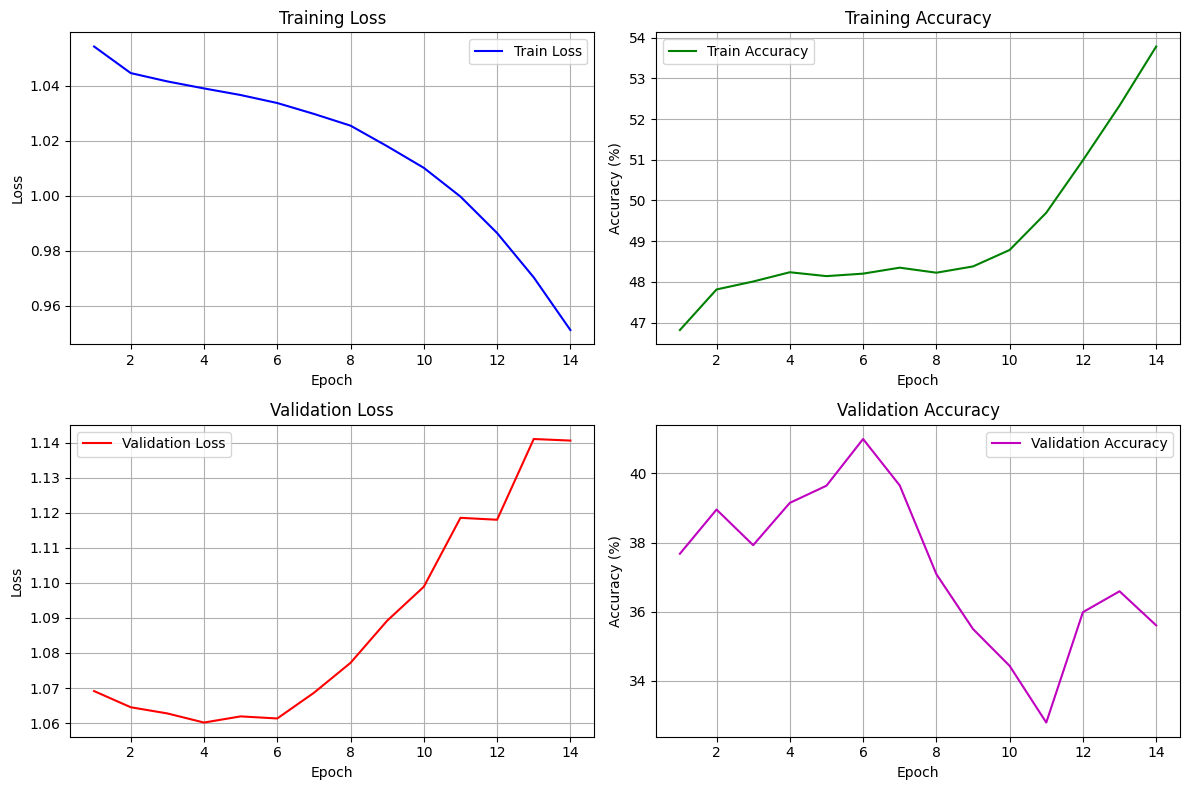

In [14]:
import matplotlib.pyplot as plt
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    """
    Vẽ biểu đồ kết quả huấn luyện: loss và accuracy cho train và validation.
    
    Parameters:
    - train_losses: List các giá trị loss của train qua các epoch
    - train_accs: List các giá trị accuracy của train qua các epoch
    - val_losses: List các giá trị loss của validation qua các epoch
    - val_accs: List các giá trị accuracy của validation qua các epoch
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Tạo figure với 2x2 subplot
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Train Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accs, 'g-', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 4: Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accs, 'm-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, train_accs, val_losses, val_accs)

In [15]:
torch.save(model.state_dict(), 'model.pth')

In [16]:
def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)  # [B, seq_len, n_features]
            batch_y = batch_y.to(device)

            outputs = model(batch_x)  # Expecting [B, num_classes]
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    target_names = ['BUY', 'SELL', 'HOLD']
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion matrix:')
    print(pd.DataFrame(cm, columns=target_names, index=target_names))
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4, zero_division=0))

In [17]:
test_model(model, train_loader, DEVICE)

Confusion matrix:
        BUY  SELL   HOLD
BUY   25700  2424   3957
SELL  12409  4629   4558
HOLD  25286  4125  21933
Classification Report:
              precision    recall  f1-score   support

         BUY     0.4054    0.8011    0.5384     32081
        SELL     0.4141    0.2143    0.2825     21596
        HOLD     0.7203    0.4272    0.5363     51344

    accuracy                         0.4976    105021
   macro avg     0.5133    0.4809    0.4524    105021
weighted avg     0.5612    0.4976    0.4847    105021



In [18]:
test_model(model, val_loader, DEVICE)

Confusion matrix:
       BUY  SELL  HOLD
BUY   3667  6562  1219
SELL  1684  4935  1034
HOLD  2474  9616  3887
Classification Report:
              precision    recall  f1-score   support

         BUY     0.4686    0.3203    0.3805     11448
        SELL     0.2337    0.6448    0.3431      7653
        HOLD     0.6331    0.2433    0.3515     15977

    accuracy                         0.3560     35078
   macro avg     0.4451    0.4028    0.3584     35078
weighted avg     0.4923    0.3560    0.3591     35078



In [19]:
test_model(model, test_loader, DEVICE)

Confusion matrix:
        BUY   SELL  HOLD
BUY   10006  24736  1873
SELL   4899  17948  1600
HOLD   7607  38613  5435
Classification Report:
              precision    recall  f1-score   support

         BUY     0.4445    0.2733    0.3385     36615
        SELL     0.2208    0.7342    0.3395     24447
        HOLD     0.6101    0.1052    0.1795     51655

    accuracy                         0.2962    112717
   macro avg     0.4251    0.3709    0.2858    112717
weighted avg     0.4719    0.2962    0.2658    112717



In [20]:
def get_prediction(model, inputs, device):
    # inputs = [B, S, N]
    model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)
    return preds.cpu().numpy()

In [21]:
batch = next(iter(test_loader))
inputs, labels = batch[0], batch[1]

get_prediction(model, inputs, DEVICE)

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 0, 1, 1])